Số lượng Features: 150
Số lượng mẫu Train: 3043
Số lượng mẫu Test : 7135
Tỷ lệ TDE trong Train: 4.86%

===== BẮT ĐẦU TRAINING (5 Folds) =====

--- Fold 1 / 5 ---
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 1	valid's auc: 0.863961
[200]	train's auc: 1	valid's auc: 0.883592
[300]	train's auc: 1	valid's auc: 0.894646
[400]	train's auc: 1	valid's auc: 0.899079
[500]	train's auc: 1	valid's auc: 0.902879
[600]	train's auc: 1	valid's auc: 0.906908
[700]	train's auc: 1	valid's auc: 0.908923
[800]	train's auc: 1	valid's auc: 0.909557
[900]	train's auc: 1	valid's auc: 0.909787
Early stopping, best iteration is:
[831]	train's auc: 1	valid's auc: 0.910248
Fold 1 AUC: 0.9102, PR-AUC: 0.4513

--- Fold 2 / 5 ---
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 1	valid's auc: 0.924467
[200]	train's auc: 1	valid's auc: 0.932067
[300]	train's auc: 1	valid's auc: 0.933679
[400]	train's auc: 1	valid's auc: 0.936615
[500]	train's auc: 1	v

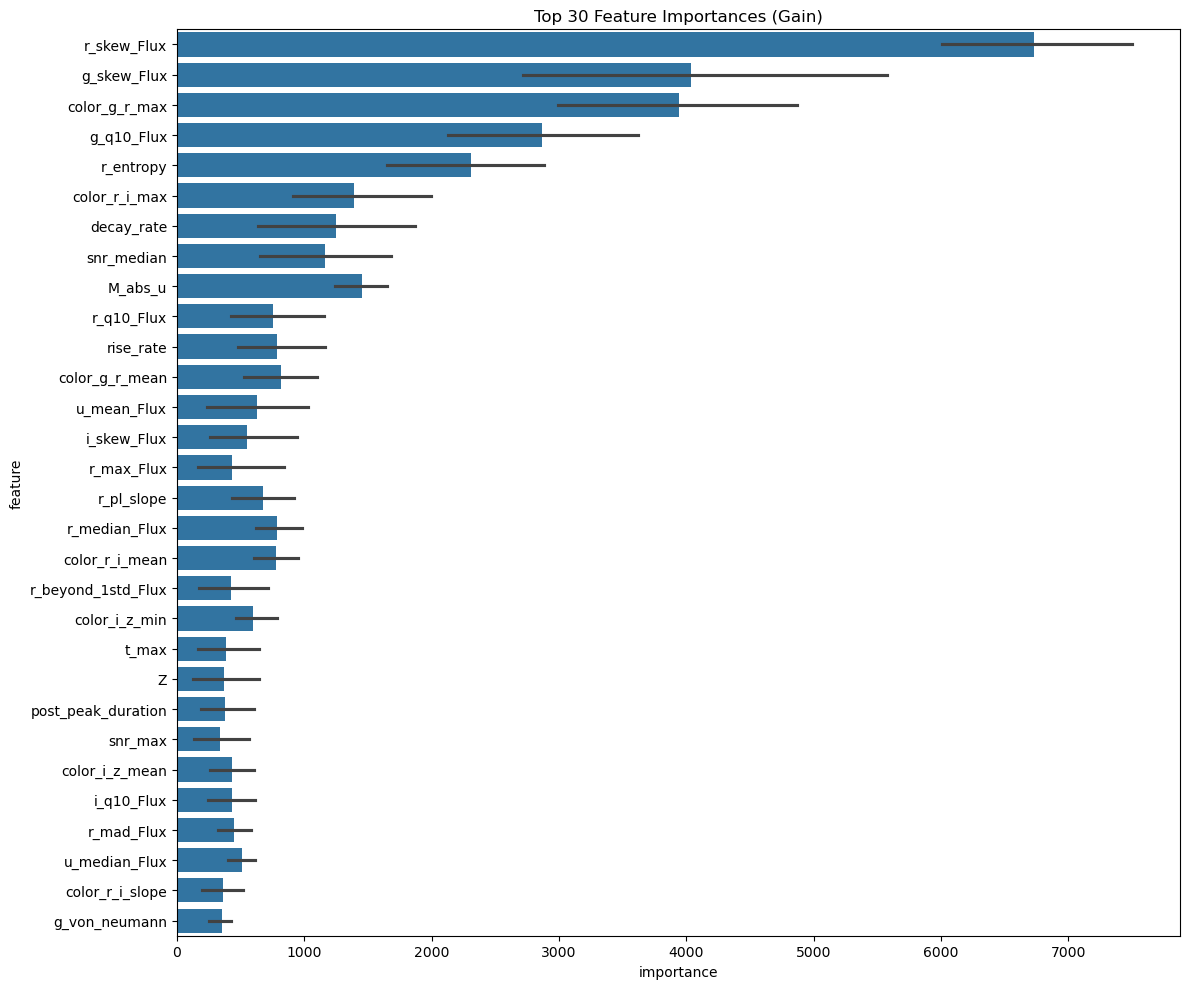


Saved submission to submission_final_v2.csv
Số lượng TDE dự đoán trong tập Test: 387


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# ====================================================
# 1. CẤU HÌNH & CHUẨN BỊ DỮ LIỆU
# ====================================================
train_df = pd.read_csv("features_out_data_feature_selection/train_features_all_splits.csv")
test_df = pd.read_csv("features_out_data_feature_selection/test_features_all_splits.csv")

# CÁC CỘT KHÔNG DÙNG ĐỂ TRAIN
IGNORE_COLS = ['object_id', 'target', 'split', 'dataset', 'fold']

# Tự động lấy danh sách features
features = [c for c in train_df.columns if c not in IGNORE_COLS]
target = 'target'

print(f"Số lượng Features: {len(features)}")
print(f"Số lượng mẫu Train: {len(train_df)}")
print(f"Số lượng mẫu Test : {len(test_df)}")
print(f"Tỷ lệ TDE trong Train: {train_df[target].mean()*100:.2f}%")

# ====================================================
# 2. CẤU HÌNH MÔ HÌNH LIGHTGBM
# ====================================================
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',                # Theo dõi AUC trong quá trình train
    'n_estimators': 10000,          # Số lượng cây tối đa (sẽ dừng sớm nhờ early_stopping)
    'learning_rate': 0.02,          # Tốc độ học chậm để hội tụ tốt hơn
    'num_leaves': 31,               # Độ phức tạp của cây
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'bagging_fraction': 0.8,        # Subsample hàng
    'feature_fraction': 0.8,        # Subsample cột
    'bagging_freq': 1,
    'lambda_l1': 0.1,               # Regularization L1
    'lambda_l2': 0.1,               # Regularization L2
    'scale_pos_weight': 5.0,        # QUAN TRỌNG: Tăng trọng số cho lớp TDE (Class 1)
    'n_jobs': -1,
    'verbose': -1,
    'random_state': 42
}

# ====================================================
# 3. TRAINING LOOP (STRATIFIED K-FOLD)
# ====================================================
N_FOLDS = 5
folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(train_df))     # Out-of-fold predictions (để đánh giá nội bộ)
test_preds = np.zeros(len(test_df))     # Predictions cho tập test
feature_importance_df = pd.DataFrame()

print(f"\n===== BẮT ĐẦU TRAINING ({N_FOLDS} Folds) =====")

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df, train_df[target])):
    print(f"\n--- Fold {fold_ + 1} / {N_FOLDS} ---")
    
    # Chia dữ liệu
    X_trn, y_trn = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx][target]
    X_val, y_val = train_df.iloc[val_idx][features], train_df.iloc[val_idx][target]
    
    # Tạo Dataset cho LightGBM
    dtrain = lgb.Dataset(X_trn, label=y_trn)
    dval = lgb.Dataset(X_val, label=y_val)
    
    # Train
    clf = lgb.train(
        lgb_params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100)
        ]
    )
    
    # Predict Validation (OOF)
    val_pred = clf.predict(X_val, num_iteration=clf.best_iteration)
    oof_preds[val_idx] = val_pred
    
    # Predict Test (cộng dồn để lấy trung bình sau này)
    test_preds += clf.predict(test_df[features], num_iteration=clf.best_iteration) / N_FOLDS
    
    # Lưu Feature Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # In điểm số sơ bộ của Fold
    score = roc_auc_score(y_val, val_pred)
    pr_auc = average_precision_score(y_val, val_pred)
    print(f"Fold {fold_ + 1} AUC: {score:.4f}, PR-AUC: {pr_auc:.4f}")

    del X_trn, X_val, y_trn, y_val, clf, dtrain, dval
    gc.collect()

# ====================================================
# 4. ĐÁNH GIÁ TỔNG THỂ & TÌM NGƯỠNG TỐI ƯU
# ====================================================
print("\n===== ĐÁNH GIÁ TỔNG THỂ (OOF) =====")
overall_auc = roc_auc_score(train_df[target], oof_preds)
overall_pr_auc = average_precision_score(train_df[target], oof_preds)
print(f"Overall AUC: {overall_auc:.5f}")
print(f"Overall PR-AUC: {overall_pr_auc:.5f}")

# Tìm Threshold tối ưu hóa F1-Score
best_thresh = 0
best_f1 = 0
for thresh in np.arange(0.1, 0.9, 0.01):
    pred_labels = (oof_preds >= thresh).astype(int)
    f1 = f1_score(train_df[target], pred_labels)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"\nNgưỡng tối ưu (Best Threshold): {best_thresh:.2f}")
print(f"Max F1-Score: {best_f1:.4f}")

# Confusion Matrix tại ngưỡng tối ưu
final_oof_labels = (oof_preds >= best_thresh).astype(int)
cm = confusion_matrix(train_df[target], final_oof_labels)
print("\nConfusion Matrix:")
print(cm)
print(classification_report(train_df[target], final_oof_labels))

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(12, 10))
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('Top 30 Feature Importances (Gain)')
plt.tight_layout()
plt.show()

# ====================================================
# 5. TẠO FILE SUBMISSION
# ====================================================
# Áp dụng ngưỡng tối ưu vào tập Test
# test_df['pred_prob'] = test_preds # Lưu xác suất gốc
test_df['target'] = (test_preds >= best_thresh).astype(int)

# Lưu kết quả
submission = test_df[['object_id', 'target']]
submission.to_csv("submission_final.csv_v2", index=False)
print(f"\nSaved submission to submission_final_v2.csv")
print(f"Số lượng TDE dự đoán trong tập Test: {submission['target'].sum()}")

In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, 
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import warnings

warnings.filterwarnings('ignore')

# ==============================================================================
# CẤU HÌNH HỆ THỐNG
# ==============================================================================
CONFIG = {
    'N_FOLDS': 5,
    'RANDOM_STATE': 42,
    'TARGET_COL': 'target',
    'ID_COL': 'object_id',
    'IGNORE_COLS': ['object_id', 'target', 'split', 'dataset', 'fold'],
    
    'TRAIN_PATH': "features_out_data_feature_selection/train_features_all_splits.csv",
    'TEST_PATH': "features_out_data_feature_selection/test_features_all_splits.csv",
    'OUTPUT_DIR': "catboost_results_optimized"
}

# Tạo thư mục lưu kết quả
os.makedirs(CONFIG['OUTPUT_DIR'], exist_ok=True)

print("Đã khởi tạo cấu hình xong.")

✅ Đã khởi tạo cấu hình xong.


In [ ]:
def load_data(cfg):
    print(" Đang tải dữ liệu...")
    
    if not os.path.exists(cfg['TRAIN_PATH']) or not os.path.exists(cfg['TEST_PATH']):
        raise FileNotFoundError(" Không tìm thấy file dữ liệu feature!")
        
    train_df = pd.read_csv(cfg['TRAIN_PATH'])
    test_df = pd.read_csv(cfg['TEST_PATH'])
    
    # Lấy danh sách feature
    features = [c for c in train_df.columns if c not in cfg['IGNORE_COLS']]
    
    # Kiểm tra mất cân bằng
    n_pos = train_df[cfg['TARGET_COL']].sum()
    n_neg = len(train_df) - n_pos
    ratio = n_neg / n_pos
    
    print(f"Thống kê dữ liệu:")
    print(f"   - Train Shape: {train_df.shape}")
    print(f"   - Test Shape:  {test_df.shape}")
    print(f"   - Số lượng Feature: {len(features)}")
    print(f"   - Tỷ lệ lớp (Imbalance Ratio): 1:{ratio:.2f} (Pos={n_pos}, Neg={n_neg})")
    
    return train_df, test_df, features

# Load dữ liệu
train_df, test_df, features = load_data(CONFIG)

⏳ Đang tải dữ liệu...
📊 Thống kê dữ liệu:
   - Train Shape: (3043, 154)
   - Test Shape:  (7135, 153)
   - Số lượng Feature: 150
   - Tỷ lệ lớp (Imbalance Ratio): 1:19.56 (Pos=148, Neg=2895)


In [ ]:
def train_catboost(train_df, test_df, features, cfg):
    print(f"\nBẮT ĐẦU HUẤN LUYỆN CATBOOST ({cfg['N_FOLDS']} Folds)...")
    
    folds = StratifiedKFold(n_splits=cfg['N_FOLDS'], shuffle=True, random_state=cfg['RANDOM_STATE'])
    
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    feature_importances = pd.DataFrame()
    
    cat_params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'iterations': 5000,              # Số cây tối đa
        'learning_rate': 0.03,           # Tốc độ học chậm và chắc
        'depth': 8,                      # Cây sâu hơn để bắt pattern khó
        'l2_leaf_reg': 3.0,              # Regularization
        'random_seed': cfg['RANDOM_STATE'],
        'auto_class_weights': 'Balanced', 
        'bootstrap_type': 'Bayesian',    # Tốt hơn cho dataset nhỏ/vừa
        'bagging_temperature': 1,
        'allow_writing_files': False,
        'thread_count': 4,
        'verbose': 500,                  # In log mỗi 500 vòng
        'early_stopping_rounds': 200     # Dừng sớm nếu không cải thiện
    }

    for fold, (trn_idx, val_idx) in enumerate(folds.split(train_df, train_df[cfg['TARGET_COL']])):
        X_trn, y_trn = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx][cfg['TARGET_COL']]
        X_val, y_val = train_df.iloc[val_idx][features], train_df.iloc[val_idx][cfg['TARGET_COL']]
        
        # Tạo Pool
        train_pool = Pool(X_trn, y_trn)
        val_pool = Pool(X_val, y_val)
        
        # Train
        model = CatBoostClassifier(**cat_params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True)
        
        # Predict
        val_pred = model.predict_proba(X_val)[:, 1]
        test_pred_fold = model.predict_proba(test_df[features])[:, 1]
        
        # Lưu kết quả
        oof_preds[val_idx] = val_pred
        test_preds += test_pred_fold / cfg['N_FOLDS']
        
        # Feature Importance
        imp_df = pd.DataFrame({
            'feature': features, 
            'importance': model.get_feature_importance(),
            'fold': fold + 1
        })
        feature_importances = pd.concat([feature_importances, imp_df], axis=0)
        
        print(f"   -> Fold {fold+1} AUC: {roc_auc_score(y_val, val_pred):.5f}")
        
        # Dọn dẹp RAM
        del X_trn, X_val, y_trn, y_val, train_pool, val_pool, model
        gc.collect()

    print(f"\n🏆 OOF AUC Tổng thể: {roc_auc_score(train_df[cfg['TARGET_COL']], oof_preds):.6f}")
    return oof_preds, test_preds, feature_importances

# Thực thi Train
oof_preds, test_preds, feat_imp = train_catboost(train_df, test_df, features, CONFIG)


🚀 BẮT ĐẦU HUẤN LUYỆN CATBOOST (5 Folds)...
0:	test: 0.7749856	best: 0.7749856 (0)	total: 117ms	remaining: 9m 46s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9181922855
bestIteration = 277

Shrink model to first 278 iterations.
   -> Fold 1 AUC: 0.91819
0:	test: 0.7482441	best: 0.7482441 (0)	total: 105ms	remaining: 8m 43s
500:	test: 0.9257916	best: 0.9258492 (492)	total: 49.8s	remaining: 7m 27s
1000:	test: 0.9290155	best: 0.9294761 (854)	total: 1m 50s	remaining: 7m 21s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9294761082
bestIteration = 854

Shrink model to first 855 iterations.
   -> Fold 2 AUC: 0.92948
0:	test: 0.7891192	best: 0.7891192 (0)	total: 189ms	remaining: 15m 43s
500:	test: 0.9544617	best: 0.9548071 (469)	total: 1m 4s	remaining: 9m 37s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9553252735
bestIteration = 598

Shrink model to first 599 iterations.
   -> Fold 3 AUC: 0.95533
0:	test: 0.8239235	best: 0


🎯 F1-Maximization Threshold Search:
   - Ngưỡng tối ưu: 0.2271
   - Max F1-Score: 0.5472

📊 Báo cáo phân loại (Classification Report - Train):
              precision    recall  f1-score   support

     Non-TDE       0.98      0.97      0.98      2895
         TDE       0.51      0.59      0.55       148

    accuracy                           0.95      3043
   macro avg       0.75      0.78      0.76      3043
weighted avg       0.96      0.95      0.95      3043



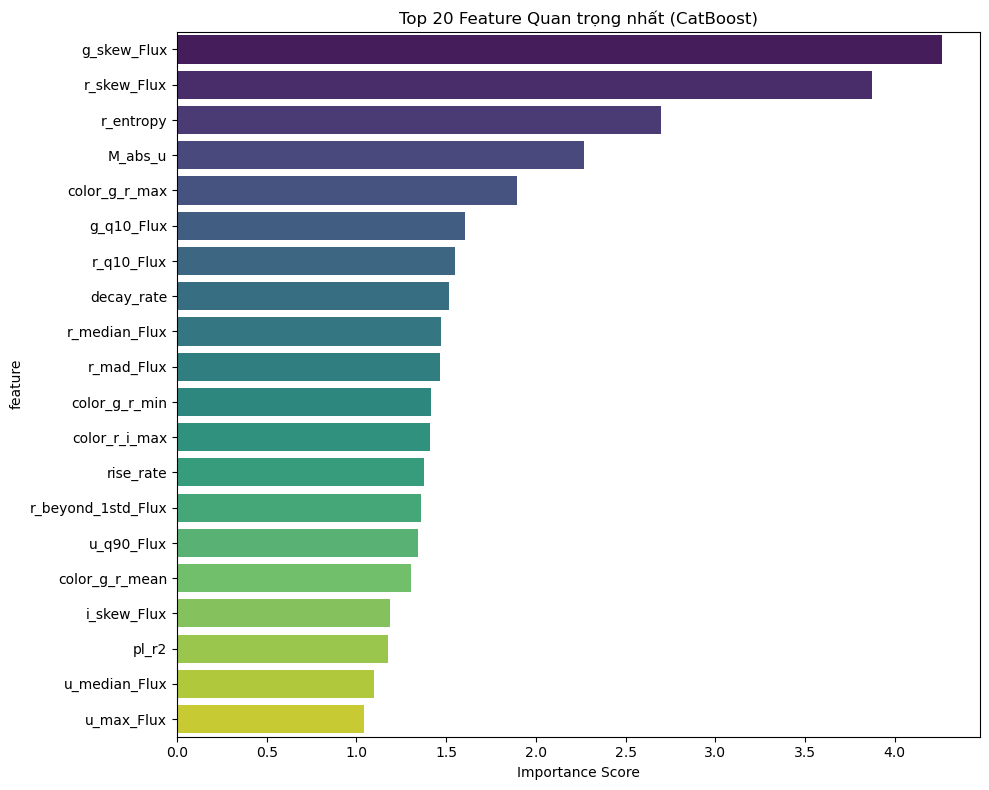

In [ ]:
def find_best_threshold_f1(y_true, y_pred):
    """Tìm ngưỡng cắt dựa trên F1-Score tối đa"""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    print(f"\nF1-Maximization Threshold Search:")
    print(f"   - Ngưỡng tối ưu: {best_thresh:.4f}")
    print(f"   - Max F1-Score: {best_f1:.4f}")
    
    return best_thresh

# Tìm ngưỡng
best_threshold = find_best_threshold_f1(train_df[CONFIG['TARGET_COL']], oof_preds)

# Đánh giá chi tiết
y_pred_binary = (oof_preds >= best_threshold).astype(int)
print("\nBáo cáo phân loại (Classification Report - Train):")
print(classification_report(train_df[CONFIG['TARGET_COL']], y_pred_binary, target_names=['Non-TDE', 'TDE']))

# Vẽ Feature Importance (Top 20)
plt.figure(figsize=(10, 8))
avg_imp = feat_imp.groupby("feature")["importance"].mean().sort_values(ascending=False).head(20)
sns.barplot(x=avg_imp.values, y=avg_imp.index, palette='viridis')
plt.title('Top 20 Feature Quan trọng nhất (CatBoost)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [ ]:
def create_submission(test_df, test_preds, threshold, cfg):
    print("\nĐang tạo file Submission...")
    
    submission = pd.DataFrame()
    submission[cfg['ID_COL']] = test_df[cfg['ID_COL']]
    submission['pred_prob'] = test_preds
    
    # Áp dụng ngưỡng đã tìm được (Data-driven Threshold)
    submission[cfg['TARGET_COL']] = (submission['pred_prob'] >= threshold).astype(int)
    
    # Thống kê kết quả
    n_tde = submission[cfg['TARGET_COL']].sum()
    print(f"   - Tổng số TDE dự đoán: {n_tde}")
    print(f"   - Ngưỡng áp dụng: {threshold:.4f}")
    
    if 300 <= n_tde <= 500:
        print(" Kết quả nằm trong vùng an toàn (300-500).")
    else:
        print(" Cảnh báo: Số lượng dự đoán hơi lệch so với kỳ vọng.")

    # Lưu file
    save_path = f"{cfg['OUTPUT_DIR']}/submission_catboost_f1_optimized.csv"
    submission[[cfg['ID_COL'], cfg['TARGET_COL']]].to_csv(save_path, index=False)
    print(f" Đã lưu file tại: {save_path}")

# Tạo submission
create_submission(test_df, test_preds, best_threshold, CONFIG)


💾 Đang tạo file Submission...
   - Tổng số TDE dự đoán: 386
   - Ngưỡng áp dụng: 0.2271
✅ Kết quả nằm trong vùng an toàn (300-500).
✅ Đã lưu file tại: catboost_results_optimized/submission_catboost_f1_optimized.csv
